In [27]:
import streamlit as st

import numpy as np
import pandas as pd
from scipy import stats
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime,timedelta
mpl.rcParams['figure.figsize'] = (18,12)

import psycopg2
import sys

import plotly.express as px
import plotly.graph_objects as go

import holidays

sns.set()
sns.set_style('whitegrid')

import statsmodels.api as sm
from sklearn import linear_model as lm

In [2]:
param_dic = {
    "host"      : "localhost",
    "database"  : "demand",
    "user"      : "postgres",
    "password"  : "password"
}

def connect(params_dic):
    """ Connect to the PostgreSQL database server """
    conn = None
    try:
        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(**params_dic)
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        sys.exit(1) 
    print("Connection successful")
    return conn

def postgresql_to_dataframe(conn, select_query, column_names):
    """
    Tranform a SELECT query into a pandas dataframe
    """
    cursor = conn.cursor()
    try:
        cursor.execute(select_query)
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        cursor.close()
        return 1
    
    tupples = cursor.fetchall()
    cursor.close()
    
    data = pd.DataFrame(tupples, columns=column_names)
    return data

In [3]:
def deal_with_holidays(end_year,start_year=2018):
    
    data['holidays'] = 0
    holiday = holidays.Canada()
    hol_list = holiday[start_year:end_year]
    for date in hol_list:
        data.loc[datetime.strftime(date,'%Y-%m-%d'),'holidays'] = 1
        
def deal_with_dayofweek(x):
    if x == 'Weekday':
        return 1
    if x == 'Weekend':
        return 0

In [4]:
conn = connect(param_dic)

column_names = ['timestamp', 'hour', 'temp_index', 'week_index', 'temperature', 'demand']

query = ("SELECT temp_data.timestamp,hour,temp_index,week_index,temperature,demand_data.demand" 
         " FROM temp_data LEFT JOIN demand_data ON temp_data.timestamp = demand_data.timestamp"
         " ORDER BY timestamp")


data = postgresql_to_dataframe(conn, query, column_names)
data.set_index('timestamp',inplace=True)

Connecting to the PostgreSQL database...
Connection successful


In [5]:
data.dropna(inplace=True)

2021-02-22 11:47:37.959 INFO    numexpr.utils: NumExpr defaulting to 8 threads.


In [6]:
display(data.head())
display(data.shape)

,hour,temp_index,week_index,temperature,demand
timestamp,,,,,
2018-01-01 00:00:00,0,NotHot,Weekday,-19.5,5340.0
2018-01-01 01:00:00,1,NotHot,Weekday,-21.7,5211.0
2018-01-01 02:00:00,2,NotHot,Weekday,-19.3,5096.0
2018-01-01 03:00:00,3,NotHot,Weekday,-20.3,4987.0
2018-01-01 04:00:00,4,NotHot,Weekday,-19.9,4926.0


(27501, 5)

In [7]:
end_year = data.reset_index().iloc[-1]['timestamp'].year
deal_with_holidays(end_year)

In [8]:
display(data.head())
display(data.shape)

,hour,temp_index,week_index,temperature,demand,holidays
timestamp,,,,,,
2018-01-01 00:00:00,0,NotHot,Weekday,-19.5,5340.0,0
2018-01-01 01:00:00,1,NotHot,Weekday,-21.7,5211.0,0
2018-01-01 02:00:00,2,NotHot,Weekday,-19.3,5096.0,0
2018-01-01 03:00:00,3,NotHot,Weekday,-20.3,4987.0,0
2018-01-01 04:00:00,4,NotHot,Weekday,-19.9,4926.0,0


(27501, 6)

In [9]:
hour_dummy_data = pd.get_dummies(data['hour'])
display(hour_dummy_data.head())
display(hour_dummy_data.shape)

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-01-01 01:00:00,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-01-01 02:00:00,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-01-01 03:00:00,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-01-01 04:00:00,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(27501, 24)

In [10]:
data = pd.concat([data, hour_dummy_data], axis=1)
data['dayofweek'] = data['week_index'].map(deal_with_dayofweek)
data.drop(['hour',23,'temp_index','week_index'],axis=1,inplace=True)
demand = data.pop('demand')
data['demand'] = demand

In [11]:
display(data.head())
display(data.shape)

,temperature,holidays,0,1,2,3,4,5,6,7,...,15,16,17,18,19,20,21,22,dayofweek,demand
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,-19.5,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,5340.0
2018-01-01 01:00:00,-21.7,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,5211.0
2018-01-01 02:00:00,-19.3,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,5096.0
2018-01-01 03:00:00,-20.3,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,4987.0
2018-01-01 04:00:00,-19.9,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,4926.0


(27501, 27)

In [16]:
def my_data(data,pred_start):   
    
    train_end = (datetime.strptime(pred_start,'%Y-%m-%d') - timedelta(days=1)).strftime('%Y-%m-%d')
    
    pred_day = data.loc[pred_start:]
    train_days = data.loc[:train_end]
    
    y_train = train_days['demand'].to_numpy().reshape(-1, 1)
    X_train = train_days.loc[:, train_days.columns != 'demand']
    y_test = pred_day['demand'].to_numpy().reshape(-1, 1)
    X_test = pred_day.loc[:, pred_day.columns != 'demand']
    
    return X_train, X_test, y_train, y_test

In [42]:
X_train, X_test, y_train, y_test = my_data(data,'2021-01-01')

In [43]:
display(X_train.shape)
display(X_test.shape)
display(y_train.shape)
display(y_test.shape)

(26301, 26)

(1200, 26)

(26301, 1)

(1200, 1)

In [44]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

model = sm.OLS(y_train,X_train).fit()

display(model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     1367.
Date:                Mon, 22 Feb 2021   Prob (F-statistic):               0.00
Time:                        12:00:20   Log-Likelihood:            -2.0832e+05
No. Observations:               26301   AIC:                         4.167e+05
Df Residuals:                   26275   BIC:                         4.169e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4586.0634     21.393    214.375      0.000    4544.133    4627.994
temperature    12.9702      0.379     34.206      0.000      12.227      13.713
holidays    -6.541e-13   1.01e-14    -65.065      0.000   -6.74e-13   -6.34e-13
0            -268.1468     28.477     -9.416      0.000    -323.963    -212.331
1            -444.0490     28.478    -15.593      0.000    -499.867    -388.231
2            -543.6847     28.499    -19.077      0.000    -599.544    -487.825
3            -565.3869     28.481    -19.851      0.000    -621.211    -509.562
4            -474.5936     28.483    -16.662      0.000    -530.422    -418.766
5            -215.9708     28.485     -7.582      0.000    -271.803    -160.139
6             195.6196     28.486      6.867      0.000     139.786     251.453
7             559.2195     28.484     19.633      0.000     503.390     615.049
8             794.4952     28.479     27.897      0.000     738.675     850.316
9             977.3598     28.476     34.322      0.000     921.545    1033.175
10           1111.0874     28.479     39.014      0.000    1055.267    1166.908
11           1182.5695     28.486     41.515      0.000    1126.736    1238.403
12           1204.3965     28.493     42.270      0.000    1148.548    1260.245
13           1192.6498     28.500     41.847      0.000    1136.788    1248.512
14           1179.2530     28.506     41.369      0.000    1123.381    1235.125
15           1205.2462     28.508     42.278      0.000    1149.369    1261.123
16           1279.4473     28.506     44.883      0.000    1223.573    1335.321
17           1339.8821     28.502     47.010      0.000    1284.017    1395.747
18           1311.7767     28.495     46.036      0.000    1255.925    1367.628
19           1226.4402     28.488     43.051      0.000    1170.602    1282.278
20           1074.6785     28.482     37.732      0.000    1018.852    1130.504
21            768.5431     28.478     26.987      0.000     712.724     824.362
22            369.5080     28.477     12.976      0.000     313.692     425.324
dayofweek     539.6897      9.110     59.240      0.000     521.833     557.546
==============================================================================
Omnibus:                     1288.897   Durbin-Watson:                   0.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1518.712
Skew:                           0.541   Prob(JB):                         0.00
Kurtosis:                       3.462   Cond. No.                     6.61e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.24e-29. This might indicate that there are
strong multicollinearity problems

In [45]:
predictions = model.predict(X_test)

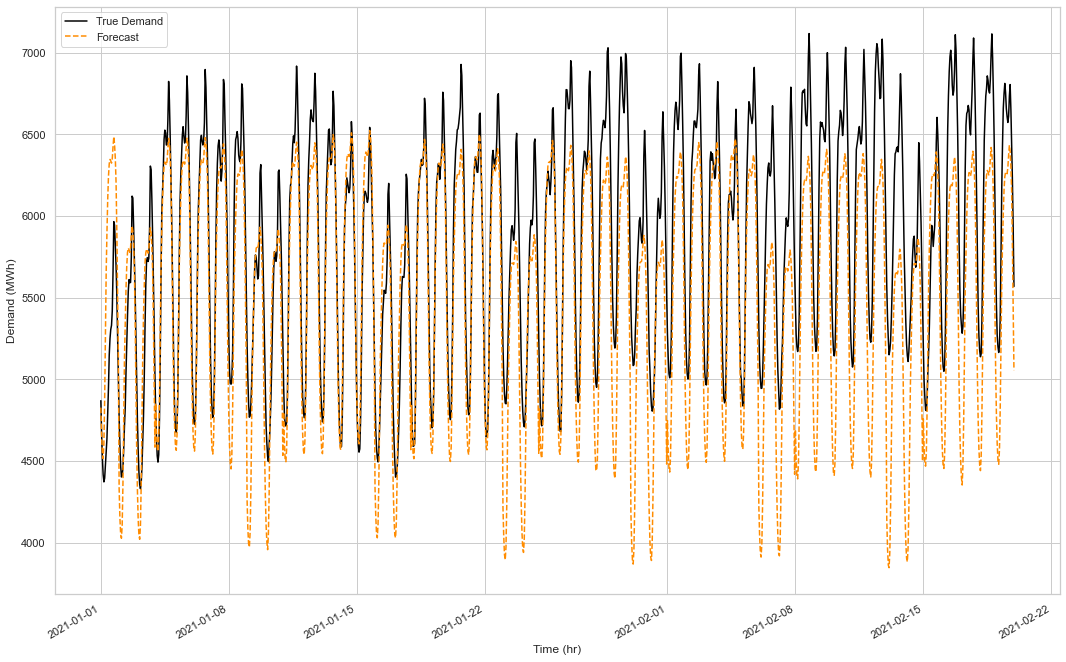

In [46]:
plt.plot(X_test.reset_index()['timestamp'], y_test, label='True Demand',color="black");
plt.plot(predictions,label='Forecast',color="darkorange",linestyle='dashed')
plt.gcf().autofmt_xdate();
plt.legend();
plt.xlabel('Time (hr)');
plt.ylabel('Demand (MWh)');